In [5]:
!pip install tushare quandl

In [24]:
#Token should be registered in official site

In [6]:
import tushare
tushare.set_token('e2hfe9hf9e9he29hfg9eh29f2hf93h9h9ehfg9whf9e2hf9')


In [7]:
import quandl
import pandas as pd
from sklearn import preprocessing, model_selection, svm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import math
import numpy as np


In [8]:
ts = tushare.pro_api()
stock = ts.cb_daily(ts_code='113503.SH')


In [10]:
df = stock.sort_values(by='trade_date')
df = df[['open', 'high', 'low', 'close', 'vol']]


In [11]:
#构造新特征
df['HL_PCT'] = (df['high'] - df['low']) / df['low'] * 100.0
df['PCT_change'] = (df['close'] - df['open']) / df['open'] * 100.0
df = df[['close', 'HL_PCT', 'PCT_change', 'vol']]
#去除首日和末日，避免报错
df = df.dropna()
df

,close,HL_PCT,PCT_change,vol
581,101.80,7.192254,-5.740741,95058.0
580,102.51,1.011291,0.224873,22529.0
579,103.81,1.511016,1.002140,8186.0
578,104.98,1.729302,1.127059,10154.0
577,104.76,1.588065,-0.437179,8075.0
...,...,...,...,...
5,139.14,7.657756,-4.698630,147592.0
4,136.92,8.955224,-5.572414,123300.0
3,126.61,10.521312,-6.595352,110078.0
2,125.20,11.760000,-4.339853,183499.0


In [16]:
#生成训练和测试集
forecast_col = 'close'
forecast_out = int(math.ceil(0.2*len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)
X = np.array(df.drop(['label'],axis=1))
X = X[:-forecast_out]                                                                         #print('删掉label列的df:{}'.format(X))
X = preprocessing.scale(X)
# 生成建立模型的y
# 抛弃label列中为空的那些行
df.dropna(inplace=True)
y = np.array(df['label'])
#预测时的的输入数据集X_lately
X_lately = X[-forecast_out:]
# 划分训练集和测试集
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

model_selection.train_test_split(X, y, test_size=0.2)

[array([[-7.34239907e-01, -3.73410698e-01,  5.66765719e-01,
         -3.58121778e-01],
        [-5.17209838e-01, -5.01430801e-01,  3.15373206e-01,
         -3.56648195e-01],
        [ 4.16124836e-03, -3.77597651e-02,  1.01082481e+00,
         -3.20946747e-01],
        ...,
        [-6.30298303e-01, -2.41550760e-01, -3.62730585e-01,
         -3.55569963e-01],
        [ 1.15001349e+00,  1.19351989e+00,  1.73833820e+00,
          4.24616689e+00],
        [-7.25093046e-01, -3.60850855e-01,  3.54824592e-01,
         -3.59176049e-01]]),
 array([[-3.84996117e-01,  1.15239942e-01,  1.18572742e+00,
         -3.47668921e-01],
        [-9.35470853e-01, -4.77377509e-01, -1.49547257e-02,
         -3.52371209e-01],
        [ 2.57778762e-01,  8.76198652e-01,  1.00173348e+00,
         -1.93829228e-01],
        [ 1.27723802e+00,  2.81164049e-01, -1.17414552e+00,
         -1.85814373e-01],
        [-1.18409917e+00, -5.62716407e-01, -2.29866231e-01,
         -3.49052652e-01],
        [-6.41108230e-01, -4

In [17]:
clf = LinearRegression(n_jobs=-1)#分别替换为lasso和Ridge即可
clf.fit(X_train, y_train)
#预测
forecast_set = clf.predict(X_lately)
#准确性探究
accuracy = clf.score(X_test, y_test)
print('预测结果为：\n{}\n模型评分为：{}'.format(forecast_set, accuracy))


预测结果为：
[103.1983074  117.00464242 125.68650432 123.33113825 109.42303676
 118.53301458 123.72248718 125.1656246  121.49381182 120.58212586
 112.79066776 127.46472885 163.70009012 189.16310878 375.63663764
 110.28413281 185.28916093 182.25706606 170.79518194 163.34596307
 159.61024073 156.69166418 171.78397588 164.01526754 157.59217226
 158.61157095 165.76798577 151.50985936 148.3338979  137.45785027
 116.43052514 134.14712041 148.03220169 157.44180788 145.16852063
 162.04977446 128.20046927 103.40084678 127.94855733 171.55560395
 178.21956326 190.90104249 200.46120082 180.29609577 152.37223441
 177.12674547 205.28687401 193.36595547 221.65069686 222.4440894
 231.12959955 215.10782729 201.71399036 187.63639265 166.40037499
 193.3414213  192.568945   182.38303536 185.33133401 187.4977339
 178.98836688 196.32914877 195.41434687 194.20675213 203.05336897
 213.46152484 210.7013359  187.53482181 188.45117885 233.39148334
 185.5571024  217.25549818 241.48969794 226.51741321 216.73039949
 202.

118


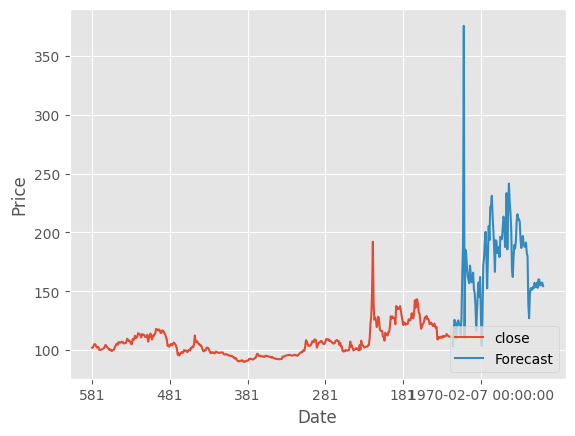

In [18]:
import matplotlib.pyplot as plt
from matplotlib import style
import datetime
style.use('ggplot')
one_day = 86400
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
print(last_date)
last_unix = pd.Timestamp(last_date).timestamp()#转换时间戳
next_unix = last_unix + one_day
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]
# 开始绘图
df['close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


预测结果为：
[106.62692786 118.49878803 124.9835549  122.55338864 111.26972072
 119.1596334  122.91975767 124.68152259 122.16921002 121.42588494
 118.82044096 136.33614516 167.26989595 198.68967872 367.27303109
 119.35627647 181.73390592 181.03600659 170.34620221 161.71535035
 161.16273879 161.58919494 172.13295108 161.42788414 156.6141856
 157.58692987 163.17001527 149.02256582 146.5778219  136.05230947
 123.5293472  136.21640495 147.55187502 154.92062455 146.59502536
 159.90610892 135.80408728 120.02269074 137.49391719 173.65267379
 178.01158607 188.20363468 195.69715571 176.42641218 163.57222788
 181.69997543 202.45370996 194.93714984 217.32192796 218.55719372
 223.24296058 208.30435225 195.76081416 182.50340336 167.30112044
 188.61908831 187.00818557 179.40304546 181.44254127 183.5578683
 178.91423587 191.93350857 191.30561475 191.1952099  200.44407659
 206.46698669 204.12487821 187.68951485 194.37622613 225.94598944
 192.10105722 216.9095438  234.11851566 218.50865107 210.95179967
 195.

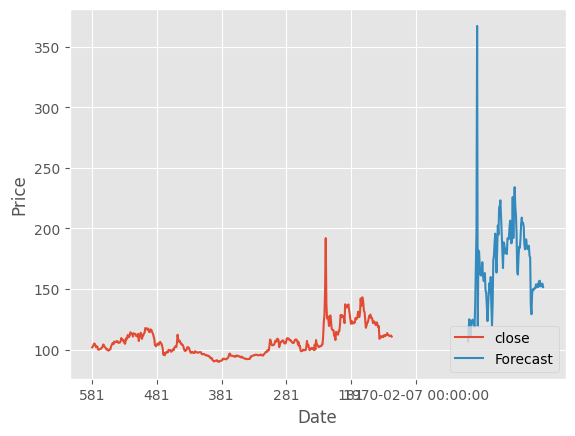

In [21]:
clf = Lasso()#分别替换为lasso和Ridge即可
clf.fit(X_train, y_train)
#预测
forecast_set = clf.predict(X_lately)
#准确性探究
accuracy = clf.score(X_test, y_test)
print('预测结果为：\n{}\n模型评分为：{}'.format(forecast_set, accuracy))
import matplotlib.pyplot as plt
from matplotlib import style
import datetime
style.use('ggplot')
one_day = 86400
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
print(last_date)
last_unix = pd.Timestamp(last_date).timestamp()#转换时间戳
next_unix = last_unix + one_day
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]
# 开始绘图
df['close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


预测结果为：
[103.43644788 117.08497863 125.68099863 123.33290038 109.54984256
 118.58305823 123.73139741 125.15929514 121.53061673 120.63158095
 112.9829773  127.68002139 163.72741099 189.13717436 374.45717382
 110.95847431 185.0522065  182.14536193 170.7531939  163.2489264
 159.63636742 156.87654816 171.76007164 163.90036331 157.52152772
 158.52077843 165.59841977 151.39265821 148.24096822 137.41143625
 116.71533278 134.29801751 147.98599043 157.27939038 145.18954723
 161.88531932 128.53873635 104.17896276 128.44884687 171.61364433
 178.16119721 190.69821112 200.09681053 180.05561977 152.62653176
 177.29497455 205.06209584 193.26903778 221.29165096 222.08765222
 230.56366102 214.62588107 201.30426668 187.30233952 166.2770295
 192.98985212 192.18772415 182.12112701 185.04410578 187.17676416
 178.8292187  195.9759439  195.08755673 193.90919866 202.74770604
 212.98461499 210.23043094 187.38350473 188.40426376 232.87860883
 185.6969517  217.08039222 240.92120607 225.97059037 216.2693583
 201.7

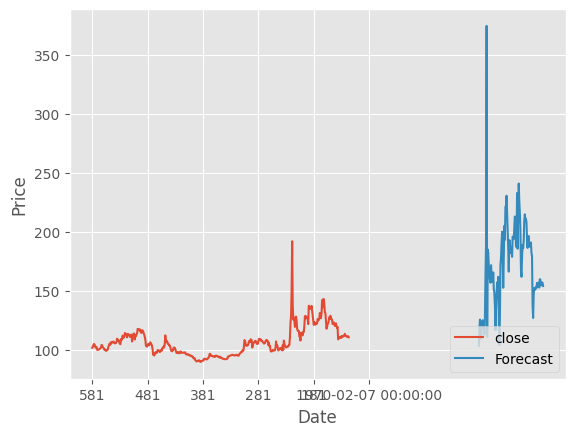

In [23]:
clf = Ridge()#分别替换为lasso和Ridge即可
clf.fit(X_train, y_train)
#预测
forecast_set = clf.predict(X_lately)
#准确性探究
accuracy = clf.score(X_test, y_test)
print('预测结果为：\n{}\n模型评分为：{}'.format(forecast_set, accuracy))
import matplotlib.pyplot as plt
from matplotlib import style
import datetime
style.use('ggplot')
one_day = 86400
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
print(last_date)
last_unix = pd.Timestamp(last_date).timestamp()#转换时间戳
next_unix = last_unix + one_day
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]
# 开始绘图
df['close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
